# Cross Validation Modeling - Statefarm Data

In [1]:
import theano
from theano.sandbox import cuda
cuda.use('gpu0')

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
IMPORT_DIR = '/home/ubuntu/nbs'
%cd $IMPORT_DIR

/home/ubuntu/nbs


In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import daveutils
from daveutils import *
import davenet
from davenet import *
import my_cv_modeler
from my_cv_modeler import *

Using Theano backend.


In [103]:
ALL_DATA_DIR = '/home/ubuntu/'
DATA_HOME_DIR = ALL_DATA_DIR+'statefarm1/'
TRAIN_DIR = DATA_HOME_DIR+'train/'
VALID_DIR = DATA_HOME_DIR+'valid/'
SAMPLE_DIR = DATA_HOME_DIR+'sample/'
MODELS_DIR = DATA_HOME_DIR+'models/'
RESULTS_DIR = DATA_HOME_DIR+'results/'
TEST_DIR = DATA_HOME_DIR+'test/'

In [5]:
batch_size=64

### 2. Restore Precalculated Conv Layers Feature Data and Merge

In [6]:
filenames_all = load_array(RESULTS_DIR+'filenames_all.bc')
filenames_all.shape


(22424,)

In [7]:
trn_labels_all = load_array(RESULTS_DIR+'trn_labels_all.bc')
trn_labels_all.shape

(22424, 10)

In [8]:
trn_classes_all = load_array(RESULTS_DIR+'trn_classes_all.bc')
trn_classes_all.shape

(22424,)

In [9]:

conv_trn_feat_all = load_array(RESULTS_DIR+'conv_trn_feat_all.bc')
conv_trn_feat_all.shape

(22424, 512, 14, 14)

In [10]:

trn_image_nums = load_array(RESULTS_DIR+'trn_image_nums.bc')
test_image_nums = load_array(RESULTS_DIR+'test_image_nums.bc')


In [11]:
conv_test_feat = load_array(RESULTS_DIR+'conv_test_feat.bc')
conv_test_feat.shape

(19726, 512, 14, 14)

### 5. Prepare Sample Weight Mask

In [12]:
bad_img_nums=np.array(['16927','101091','31121','27454','49471','47068','18737','14223','68147','68040','54867'])

In [13]:
sample_weight = np.array([0 if np.any(bad_img_nums==im) else 1 for im in trn_image_nums])
len(sample_weight)-np.count_nonzero(sample_weight)

11

In [14]:
y= (3,4)
x= 2
(x, y[0], y[1])

(2, 3, 4)

# Create Cross Validated Model Based on All Training Data

### 1. Add fc_bn layers, and train only the final layer

In [15]:
vgg = Dave16()
model = vgg.model
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [16]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [17]:
p=0.5

In [18]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
%cd $DATA_HOME_DIR

/home/ubuntu/statefarm1


In [20]:
#Utilise my_cv_modeler
nworst=50
folds=6
nb_epoch=2
#run my_cross_validation(model, train_data, train_target, filenames=filenames, nworst=nworst, ifolds=10, nb_epoch=10, modelStr=''):
(bad_ids,bad_img_nums, bad_preds) = my_cross_validation(bn_model, conv_trn_feat_all, trn_labels_all, filenames_all, nworst, folds, nb_epoch, 'old', sample_weight)

X, y, sample_weights[train_index] = (18686, 512, 14, 14) (18686, 10) (18686,)
Start KFold number 1 from 6
Train on 18686 samples, validate on 3738 samples
Epoch 1/2
18686/18686 [==============================] - 8s - loss: 0.4807 - acc: 0.8558 - val_loss: 0.0296 - val_acc: 0.9920
Epoch 2/2
18686/18686 [==============================] - 8s - loss: 0.0481 - acc: 0.9886 - val_loss: 0.0195 - val_acc: 0.9946
Predicting classes for validation fold:
3738/3738 [==============================] - 1s     
Predicting probabilities for validation fold:
3738/3738 [==============================] - 1s     
Finding the incorrectly predicted cases in the validation fold:
Finding the estimated probabilities associated with incorrectly predicted cases in the validation fold:
Sorting to find the worst offenders:
X, y, sample_weights[train_index] = (18686, 512, 14, 14) (18686, 10) (18686,)
Start KFold number 2 from 6
Train on 18686 samples, validate on 3738 samples
Epoch 1/2
18686/18686 [==================

In [21]:
bad_img_nums

array(['38427', '8131', '62871', '99733', '59392', '92769', '20076', '92225', '28231', '18370',
       '26056', '64883', '69752', '27454', '68040', '75819', '66819', '49471', '79819', '7407',
       '9170', '41743'],
      dtype='|S32')

## Find the idxs relating to the bad_img_nums 
(can't use the bad_ids because that relates to shuffled data?)

In [22]:
all_trn_image_nums = np.array([vfile[7:][:-4] for vfile in filenames_all])
all_trn_image_nums[:5]

array(['95728', '73423', '74437', '96429', '21699'],
      dtype='|S6')

In [23]:
itemindex = [np.argwhere(all_trn_image_nums==bad) for bad in bad_img_nums]
itemindex = np.concatenate(itemindex)
itemindex = np.concatenate(itemindex)
itemindex

array([ 9439, 20598,  5054, 22371,  8456,  7915,  8307, 13366, 16224,  4116,  4414, 15935,  4863,
       10710, 21380, 21476,  1668, 16547,   612, 15919, 20463, 20411])

In [24]:
itemindex.shape

(22,)

### Prepare titles for each subplot

In [25]:
title = []
title = np.core.defchararray.add(map(str,bad_preds)," ")
title = np.core.defchararray.add(title, bad_img_nums)
title = np.core.defchararray.add(title," ")
title = np.core.defchararray.add(title,map(str,trn_classes_all[itemindex]))
title

array(['1 38427 4', '0 8131 5', '6 62871 2', '8 99733 9', '7 59392 4', '3 92769 4', '0 20076 4',
       '2 92225 6', '1 28231 8', '8 18370 2', '8 26056 2', '3 64883 8', '1 69752 2', '0 27454 5',
       '2 68040 7', '6 75819 7', '1 66819 0', '9 49471 8', '1 79819 0', '3 7407 8', '3 9170 4',
       '3 41743 4'],
      dtype='|S36')

## Display these images for review

In [26]:

def plots_idx(idx, titles=None):
    plots([image.load_img(TRAIN_DIR+filenames_all[i]) for i in idx], titles=titles)
    

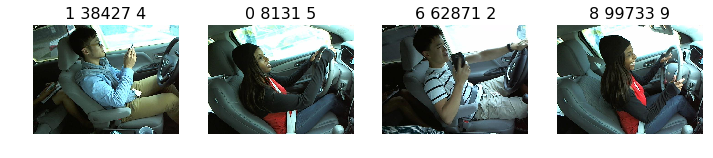

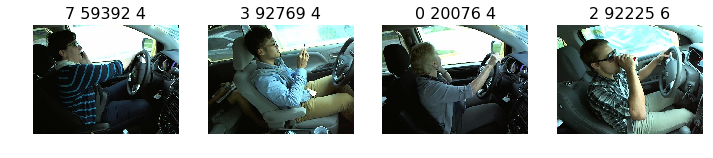

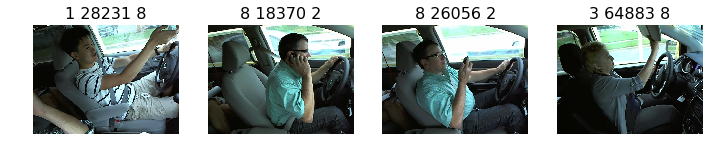

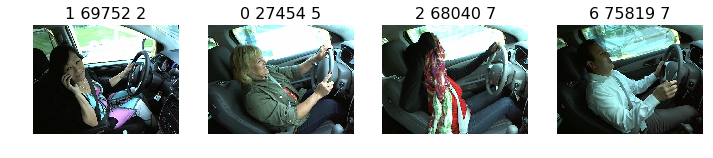

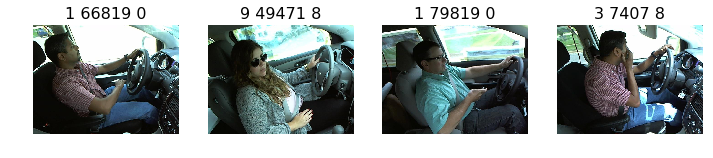

In [28]:
stride = 4
n_view = 22
nstrides = int(n_view/stride)
last_step = 0
for i in range(0,nstrides):
    next_step = min(last_step+stride, n_view-1)
    str(i) + " " + str(last_step) + " " + str(next_step)
    plots_idx(itemindex[last_step:last_step+stride],title[last_step:last_step+stride])
    last_step = last_step+stride

In [29]:
#['16927','101091','31121','27454','49471','47068','18737','14223','68147','68040','54867'])
#['38427', '8131', '62871', '99733', '59392', '92769', '20076', '92225', '28231', '18370',
#       '26056', '64883', '69752', '27454', '68040', '75819', '66819', '49471', '79819', '7407',
#       '9170', '41743']
revised_bad_img_nums = np.array(['16927','101091','31121','27454','49471','47068','18737','14223','68147','68040','54867',
                  '38427', '8131', '62871', '99733', '92769','75819', '79819'])

## Pseudo Labelling using the Ensemble Model

Add pseudo labelled data and refit the model iteratively.  Only add data for which we estimate max prob >=99.5%


In [96]:
cutoff = 0.999

In [31]:
len(conv_test_feat)

19726

In [126]:
%cd $DATA_HOME_DIR

/home/ubuntu/statefarm1


In [131]:
from keras.preprocessing import image, sequence
test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False)#class_mode='binary'

Found 79726 images belonging to 1 classes.


In [133]:
full_model = Sequential(conv_layers, get_bn_layers(p))

In [ ]:
yfull_test = []

for index in range(1, folds + 1):
    # Store test predictions
    model = read_model(index, 'old')
    test_probs = model.predict_generator(test_generator, 79700, max_q_size=10, nb_worker=1, pickle_safe=False)
    yfull_test.append(test_probs)
        
ensemble_test_probs = merge_several_folds_mean(yfull_test, folds)
ensemble_test_probs[:1]

In [33]:
len(ensemble_test_probs)

19726

In [68]:
max_test_probs = np.array([np.amax(i) for i in ensemble_test_probs])
max_test_probs[:5]

array([ 0.512,  1.   ,  0.688,  0.712,  0.999])

In [123]:
test_pseudo_labels = np.array([np.argmax(i) for i in ensemble_test_probs])
test_pseudo_labels[:5]

array([9, 7, 2, 0, 5])

In [124]:
len(test_pseudo_labels)

19726

In [44]:
np.amax(max_test_probs)

0.99999994039535522

In [97]:
row_truth = np.array([ np.greater(i,cutoff) for i in max_test_probs.T])
row_truth[:5]

array([False,  True, False, False,  True], dtype=bool)

In [91]:
len(row_truth)

19726

In [100]:
good_rows = np.array(np.where(row_truth))
len(good_rows.T)

3114

In [121]:
good_rows=np.concatenate(good_rows)
good_rows[:15]

array([  1,   4,  19,  26,  37,  52,  64,  69,  79,  92,  93, 109, 116, 132, 133])

Now plot these images to check:

In [104]:
TEST_DIR

'/home/ubuntu/statefarm1/test/'

In [111]:
test_batches = get_batches(os.path.join(DATA_HOME_DIR,'test'), shuffle=False, batch_size=1)
test_filenames = test_batches.filenames

Found 79726 images belonging to 1 classes.


In [112]:
len(test_filenames)

79726

In [115]:

def plots_idx(idx, titles=None):
    plots([image.load_img(os.path.join(TEST_DIR,test_filenames[i])) for i in idx], titles=titles)

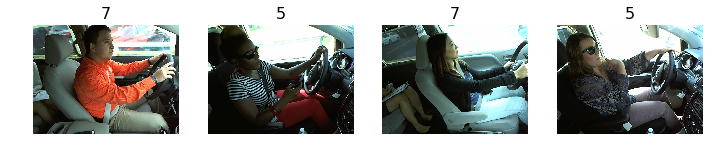

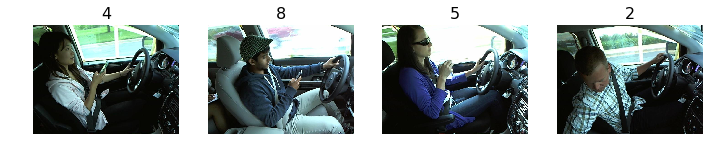

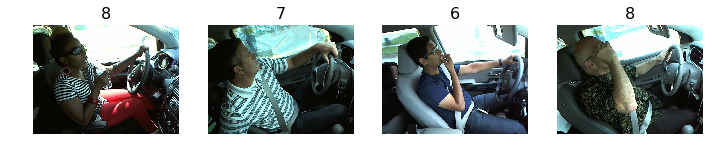

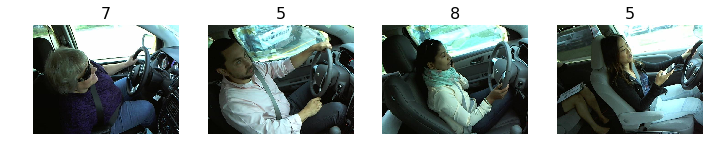

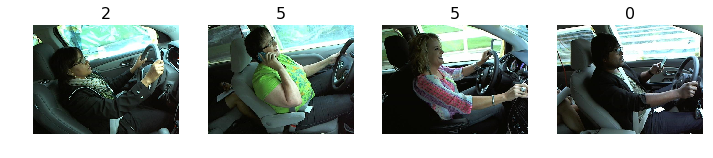

In [125]:
stride = 4
n_view = 22
nstrides = int(n_view/stride)
last_step = 0
for i in range(0,nstrides):
    next_step = min(last_step+stride, n_view-1)
    str(i) + " " + str(last_step) + " " + str(next_step)
    plots_idx(good_rows[last_step:last_step+stride],test_pseudo_labels[good_rows][last_step:last_step+stride])
    last_step = last_step+stride